In [79]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import regex as re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jczkr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Funciones para armar el dataset

In [80]:
import os
def get_hashtags_text(x):
    if pd.notna(x) and 'hashtags' in x and x['hashtags']:
        hashtags = x['hashtags']
        hashtags_text = [ht['text'] for ht in hashtags]
        return hashtags_text
    else:
        return None

def get_urls(x):
    if pd.notna(x) and 'urls' in x and x['urls']:
        return True
    return False


def get_user_location(x):
    if pd.notna(x) and 'location' in x:
        return x['location']
    else:
        return None


def load_json(file_path):
    df_new = pd.DataFrame()

    try:
        # Leer el archivo JSON línea por línea y cargar los datos en una lista
        datos_json = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)
                if 'retweeted_status' in data and data['retweeted_status'] != None:
                    data = data['retweeted_status']
                datos_json.append(data)

        df = pd.DataFrame(datos_json)

        df_new['id'] = df['id']
        df_new['lang'] = df['lang']
        df_new['text'] = df['text']
        df_new['favorite_count'] = df['favorite_count']
        df_new['retweet_count'] = df['retweet_count']
        df_new['possibly_sensitive'] = df['possibly_sensitive']
        df_new['created_at'] = df['created_at']
        df_new['is_quote_status'] = df['is_quote_status']
        df_new['entities_hashtags_text'] = df['entities'].apply(get_hashtags_text)
        df_new['entities_urls'] = df['entities'].apply(get_urls)
        df_new['user_location'] = df['user'].apply(get_user_location)
        
        # Asignar 0 a las columnas 'reply_count' y 'quote_count' si no existen
        df_new['reply_count'] = df.get('reply_count', 0)
        df_new['quote_count'] = df.get('quote_count', 0)

        # Verificar si hay al menos una imagen en el JSON
        has_image = []
        for i in range(len(df)):
            try:
                extended_entities = df['extended_entities'][i]
                if 'media' in extended_entities and len(extended_entities['media']) > 0:
                    has_image.append(True)
                else:
                    has_image.append(False)
            except (KeyError, TypeError):
                has_image.append(False)

        df_new['has_image'] = has_image

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_new


def load_jsons_from_folder(folder_path):
    df_all = pd.DataFrame()

    try:
        # Obtener la lista de archivos en la carpeta
        json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

        for file_name in json_files:
            file_path = os.path.join(folder_path, file_name)
            df = load_json(file_path)

            # Extraer el nombre del archivo sin "_final_data.json"
            json_name = file_name.replace('_final_data.json', '')

            # Agregar columna con el nombre del JSON
            df['json_name'] = json_name

            # Concatenar el DataFrame al DataFrame total
            df_all = pd.concat([df_all, df], ignore_index=True)

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_all

def read_tsv_folder(folder_path):
    df_combined = pd.DataFrame()  # DataFrame combinado para almacenar los datos de todos los archivos TSV

    # Obtener la lista de archivos en la carpeta
    file_list = os.listdir(folder_path)

    # Leer cada archivo TSV y combinar los datos en el DataFrame combinado
    for file_name in file_list:
        if file_name.endswith(".tsv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep="\t")
            df_combined = pd.concat([df_combined, df], ignore_index=True)

    return df_combined



In [81]:
# Filtrar las filas sin imágenes
#df_without_images = harvey_json.loc[harvey_json['has_image'] == 0]
#df_without_images

df_json = load_jsons_from_folder("RDATA/CrisisMMD_v2.0/json")
df_tsv = read_tsv_folder("RDATA/CrisisMMD_v2.0/annotations")

#df_tsv

### Merge datasets

In [82]:
df_json = load_jsons_from_folder("RDATA/CrisisMMD_v2.0/json")
df_tsv = read_tsv_folder("RDATA/CrisisMMD_v2.0/annotations")


In [83]:
df = pd.merge(df_json, df_tsv[['tweet_id', 'text_info', 'text_info_conf', 'text_human', 'text_human_conf']],
                    left_on='id', right_on='tweet_id', how='left')
df.drop('tweet_id',axis=1,inplace=True)
df_con_nan = df.copy()
df =  df[df['text_human'].notna()]
print(df.shape)
df_con_nan.T



(15477, 19)


,0,1,2,3,4,5,6,7,8,9,...,17622,17623,17624,17625,17626,17627,17628,17629,17630,17631
id,917791130590183424,917787635946524674,917500054742605829,917623252264062976,917792930315821057,917792147700465664,917715928271507456,917794232160661505,917433167014920192,917793736918216706,...,881612317317836800,881612317317836800,881612317317836800,881612317317836800,881632991776301056,881714673157980160,881749861871362049,881770990556131328,881807298930368513,869578299487404032
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
text,PHOTOS: Deadly wildfires rage in California ht...,Wildfires raging through Northern California a...,"PLS SHARE: We’re capturing wildfire response, ...",California's raging wildfires as you've never ...,Mass Evacuations in California as Wildfires Ki...,Wildfires Threaten California’s First Legal Ca...,Southern California fire shrouds Disneyland An...,At Least 11 Dead and 100 Missing as Wildfires ...,California wildfires destroy more than 50 stru...,California wildfire. ὡ4 https://t.co/a8oD5rkDdI,...,"Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...",https://t.co/7VqAlUWTUO My #wine tip for this ...,Get to mora and try the whole menu https://t.c...,"Mirka Mora (b.1928), noted French-born Austral...","@PaulMalignaggi Lol What u on about, Sergio Mo...",#Cameroon : 4 #female suicide #Bombers kill 1 ...,it happened during the visit of #CycloneMora o...
favorite_count,0,7,289,228,0,0,133,0,1,0,...,0,0,0,0,0,0,0,0,0,0
retweet_count,0,5,479,216,0,0,76,0,2,0,...,0,0,0,0,0,0,0,0,0,1
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Tue Oct 10 16:37:11 +0000 2017,Tue Oct 10 16:23:18 +0000 2017,Mon Oct 09 21:20:34 +0000 2017,Tue Oct 10 05:30:06 +0000 2017,Tue Oct 10 16:44:21 +0000 2017,Tue Oct 10 16:41:14 +0000 2017,Tue Oct 10 11:38:22 +0000 2017,Tue Oct 10 16:49:31 +0000 2017,Mon Oct 09 16:54:46 +0000 2017,Tue Oct 10 16:47:33 +0000 2017,...,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 21:57:39 +0000 2017,Mon Jul 03 03:22:14 +0000 2017,Mon Jul 03 05:42:03 +0000 2017,Mon Jul 03 07:06:01 +0000 2017,Mon Jul 03 09:30:17 +0000 2017,Tue May 30 15:36:37 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,None,None,None,None,[CaliforniaWildfires],None,None,None,[KAKEnews],None,...,None,None,None,None,"[wine, weekend]",None,[womensart],None,"[Cameroon, female, Bombers]",[CycloneMora]
entities_urls,True,True,True,True,True,True,True,False,True,False,...,False,False,False,False,True,False,False,False,True,False


In [84]:
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
df_con_nan = df_con_nan.drop_duplicates(subset=['id']).reset_index(drop=True)
print(df.shape)
df["id"].value_counts()

(13899, 19)


id
917791130590183424    1
913526987720921088    1
913501170173337600    1
913503821971603457    1
913507924030492672    1
                     ..
910156535011135488    1
910159570353491969    1
910160558011318279    1
910160788849008640    1
881807298930368513    1
Name: count, Length: 13899, dtype: int64

Con los datos no duplicados, se revisa la variedad de ciertas columnas. Si estás columnas solo retornan un único valor, se eliminan por redundancia.


In [85]:
df_ordenado = df_con_nan.sort_values(by='favorite_count', ascending=False)
df_ordenado.T

,11329,4177,1799,1489,6282,1801,6641,6679,7895,7484,...,5697,5698,5699,5703,5704,5706,5709,5711,5712,16053
id,915366480379809792,901172380806107136,901888489951809536,901194985885777920,907017142486401024,903656498219425792,905150466123636736,906640611071197195,905770545899286528,905954446898630656,...,905681092493139969,905681240493367296,905681247854366720,905684917375438849,905684765755424768,905683326664617984,905685544549613568,905685837362458624,905685853892169728,869578299487404032
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
text,Here's what one Puerto Rican said to me about ...,"Only in Houston, TX lol ὢDὢDὢD #HurricaneHarve...",Thanks to the Texas National Guard for their h...,Side by side satellite images compare the size...,Damn Irma fucked Orlando up https://t.co/HHDkP...,A picture worth a thousand words... #Hurricane...,"Yo Irma, right here.\n26.6771° N, 80.0370° W h...",An Indian mom will make you clean no matter wh...,Absolutely uncanny copy-paste from 7 years ago...,"Tonight, far too many people in #Irma’s path a...",...,Footage Hurricane Irma as it hits St. Maarten:...,Here’s how CFB teams are responding to Hurrica...,Hurricane Irma forces cancelation of Miami at ...,": As Hurricane #Irma nears, hospitals in Flori...",Deadly Hurricane Irma Leaves Hundreds of Thous...,Passengers from Florida land in NH as Hurrican...,Bankrupt Puerto Rico Set for Fresh Hit From Hu...,"Hurricane Irma ""...could be something not good...",Hurricane Irma Two dead and two seriously inju...,it happened during the visit of #CycloneMora o...
favorite_count,51726,43273,42379,30970,27343,24785,20799,18803,15398,15298,...,0,0,0,0,0,0,0,0,0,0
retweet_count,36840,19094,12653,25263,9512,9687,7414,2296,13661,8717,...,0,0,0,0,1,1,0,0,0,1
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Wed Oct 04 00:02:30 +0000 2017,Fri Aug 25 20:00:13 +0000 2017,Sun Aug 27 19:25:46 +0000 2017,Fri Aug 25 21:30:02 +0000 2017,Sun Sep 10 23:05:12 +0000 2017,Fri Sep 01 16:31:12 +0000 2017,Tue Sep 05 19:27:42 +0000 2017,Sat Sep 09 22:09:00 +0000 2017,Thu Sep 07 12:31:41 +0000 2017,Fri Sep 08 00:42:26 +0000 2017,...,Thu Sep 07 06:36:13 +0000 2017,Thu Sep 07 06:36:49 +0000 2017,Thu Sep 07 06:36:50 +0000 2017,Thu Sep 07 06:51:25 +0000 2017,Thu Sep 07 06:50:49 +0000 2017,Thu Sep 07 06:45:06 +0000 2017,Thu Sep 07 06:53:55 +0000 2017,Thu Sep 07 06:55:05 +0000 2017,Thu Sep 07 06:55:09 +0000 2017,Tue May 30 15:36:37 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,None,[HurricaneHarvey],[HurricaneHarvey],None,None,[HurricaneHarvey],None,None,"[Irma, Jose, Katia, Igor, Julia, Karl]",[Irma],...,None,None,None,[Irma],None,None,None,None,[RT],[CycloneMora]
entities_urls,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,True,False,True,False


In [86]:
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime as dt
df_con_nan["fecha"] = pd.to_datetime(df_con_nan['created_at'], format='%a %b %d %H:%M:%S %z %Y')
df["fecha"] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
#print(a[1000]<a[1])

#df_con_nan
#print(mdates.DateFormatter(df_con_nan['created_at']))
df_con_nan = df_con_nan[df_con_nan['fecha'] >= '2017']

In [87]:
from datetime import datetime
def foo(d):
    fecha = d
    fecha_objeto = datetime.strptime(fecha, "%b %d, %Y")
    fecha_transformada = fecha_objeto.strftime("%Y-%m-%d")

    return fecha_transformada
print(foo("Oct 10, 2017"))
l= ["Oct 10, 2017","Aug 26, 2017","Sep 6, 2017","Sep 20, 2017","Nov 13, 2017","Sep 20, 2017"]
fechas = list(map(foo,l))
print(fechas)
d1 = df_con_nan[df_con_nan['json_name']=='california_wildfires']
print(d1["fecha"])
#df_con_nan[df_con_nan['fecha']<'2017']
''' ARREGALAR RRRA
i = 0
for desastre in df_con_nan['json_name']:
    d = df_con_nan[df_con_nan['json_name']==desastre]
    df_con_nan["tdd"] = df_con_nan[(pd.to_datetime(d["fecha"]))].apply(lambda x: x-l[i])#-pd.to_datetime(l[i],))]
    i+=1
#df_con_nan[""] = df_con_nan[(pd.to_datetime(df_con_nan["fecha"])-pd.to_datetime('2017-08-17')) > 2]
#df_con_nan["fecha"]
a =pd.to_datetime('2017-07-03 07:06:01+00:00')
b=pd.to_datetime('2017-10-10 16:37:11+00:00')
c = (b-a)
print(df_con_nan)
d1'''

2017-10-10
['2017-10-10', '2017-08-26', '2017-09-06', '2017-09-20', '2017-11-13', '2017-09-20']
0      2017-10-10 16:37:11+00:00
1      2017-10-10 16:23:18+00:00
2      2017-10-09 21:20:34+00:00
3      2017-10-10 05:30:06+00:00
4      2017-10-10 16:44:21+00:00
                  ...           
1481   2017-10-27 04:00:00+00:00
1482   2017-10-27 06:19:10+00:00
1483   2017-10-27 08:01:32+00:00
1484   2017-10-27 09:29:21+00:00
1485   2017-10-27 11:49:08+00:00
Name: fecha, Length: 1482, dtype: datetime64[ns, UTC]


' ARREGALAR RRRA\ni = 0\nfor desastre in df_con_nan[\'json_name\']:\n    d = df_con_nan[df_con_nan[\'json_name\']==desastre]\n    df_con_nan["tdd"] = df_con_nan[(pd.to_datetime(d["fecha"]))].apply(lambda x: x-l[i])#-pd.to_datetime(l[i],))]\n    i+=1\n#df_con_nan[""] = df_con_nan[(pd.to_datetime(df_con_nan["fecha"])-pd.to_datetime(\'2017-08-17\')) > 2]\n#df_con_nan["fecha"]\na =pd.to_datetime(\'2017-07-03 07:06:01+00:00\')\nb=pd.to_datetime(\'2017-10-10 16:37:11+00:00\')\nc = (b-a)\nprint(df_con_nan)\nd1'

#### Contando valores 

### Embeddings

In [88]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopword_tokens
import numpy as np


# Supongamos que tienes una lista de oraciones en la columna de texto
sentences = df["text"].tolist()

stop_words = set(stopwords.words('english'))
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st','mora']
stop_words.update(additional_stop_words)

# Tokeniza las oraciones y crea una lista de listas de palabras
#tokenized_sentences = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in sentences]


# Definir los parámetros del modelo Word2Vec
vector_size = 100  # Dimensión del espacio vectorial
window_size = 5  # Tamaño de la ventana de contexto
min_count = 1  # Frecuencia mínima de las palabras para ser consideradas

def cargar_embeddings_glove(ruta_archivo):
    embeddings_index = {}
    with open(ruta_archivo, encoding='utf-8') as archivo:
        for linea in archivo:
            valores = linea.split()
            palabra = valores[0]
            vector = np.asarray(valores[1:], dtype='float32')
            embeddings_index[palabra] = vector
    return embeddings_index

ruta_archivo_glove = "glove\glove.6B.200d.txt"  # Reemplaza con la ruta real de tu archivo GloVe
embeddings_glove = cargar_embeddings_glove(ruta_archivo_glove)

# Crear y entrenar el modelo
#model = Word2Vec(tokenized_sentences, vector_size=vector_size, window=window_size, min_count=min_count)

# Obtén el vector de una palabra específica
# word = "help"
# vector = model.wv[word]
# print(f"Vector de '{word}': {vector}")

# Encuentra palabras similares a una palabra dada
# similar_words = model.wv.most_similar(word)
# print(f"Palabras similares a '{word}': {similar_words}")



In [89]:
from sklearn.model_selection import train_test_split

# Carga el dataset en un DataFrame de pandas

# Divide los datos en características (X) y etiquetas (y)
X = df['text'].values  # Reemplaza 'columna_de_texto' con el nombre real de tu columna
y = df['text_human'].values  # Reemplaza 'columna_etiquetas' con el nombre real de tu columna de etiquetas

#### clasificacion entre humanitario y no humanitario

In [90]:
y_bin = y.copy()
for i in range( len(y_bin)):
    if (y_bin[i] != 'not_humanitarian'):
        y_bin[i] = 'humanitarian'

In [91]:
# Divide los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

In [92]:
from gensim.utils import simple_preprocess
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np

stop_words = STOP_WORDS
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st','mora']
stop_words.update(additional_stop_words)

tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)


##### Linear SVC

In [93]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)


In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Accuracy: 0.7712230215827338
Precision: 0.7383987028713339
Recall: 0.6785581424234655
F1 Score: 0.6937857248255801


#### Clasificación rescue_volunteering vs human and material losses (con others incluído)

In [95]:
df_humanitarian = df[df['text_human'] != 'not_humanitarian']
x_humanitarian = df_humanitarian['text'].values
y_humanitarian = df_humanitarian['text_human'].values

In [96]:
y_bin_human = y_humanitarian.copy()
for i in range( len(y_bin_human)):
    if (y_bin_human[i] != 'rescue_volunteering_or_donation_effort'):
        y_bin_human[i] = 'human_and_material_losses'

In [97]:
X_human_train, X_human_test, y_human_train, y_human_test = train_test_split(x_humanitarian, y_bin_human, test_size=0.2, random_state=42)

In [98]:
tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_human_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_human_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)

##### Linear SVC

In [99]:
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_human_train)

y_human_pred = classifier.predict(X_test_embeddings)

In [100]:
accuracy = accuracy_score(y_human_test, y_human_pred)
precision = precision_score(y_human_test, y_human_pred,average='macro')
recall = recall_score(y_human_test, y_human_pred,average='macro')
f1 = f1_score(y_human_test, y_human_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8702675416456335
Precision: 0.8377103015859506
Recall: 0.8157208257408777
F1 Score: 0.8256661771146473


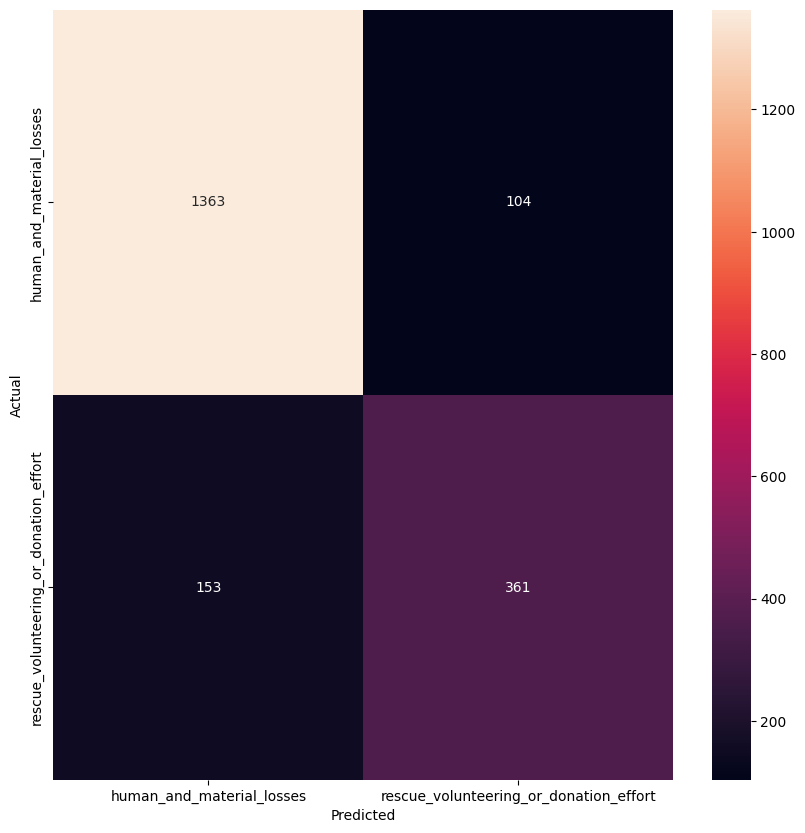

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_human_test, y_human_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=np.unique(y_bin_human), yticklabels=np.unique(y_bin_human))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Clasificación rescue_volunteering vs human and material losses vs others

In [102]:
y_tri = y_humanitarian.copy()
for i in range( len(y_tri)):
    if (y_tri[i] != 'other_relevant_information' and y_tri[i] != 'rescue_volunteering_or_donation_effort'):
        y_tri[i] = 'human_and_material_losses'

In [103]:
X_tri_train, X_tri_test, y_tri_train, y_tri_test = train_test_split(x_humanitarian, y_tri, test_size=0.2, random_state=42, stratify=y_tri)

In [104]:
tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_tri_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_tri_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)

In [105]:
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_tri_train)

y_tri_pred = classifier.predict(X_test_embeddings)

In [106]:
accuracy = accuracy_score(y_tri_test, y_tri_pred)
precision = precision_score(y_tri_test, y_tri_pred,average='macro')
recall = recall_score(y_tri_test, y_tri_pred,average='macro')
f1 = f1_score(y_tri_test, y_tri_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7435638566380616
Precision: 0.7283755699122539
Recall: 0.6847278059412208
F1 Score: 0.6982466905368061


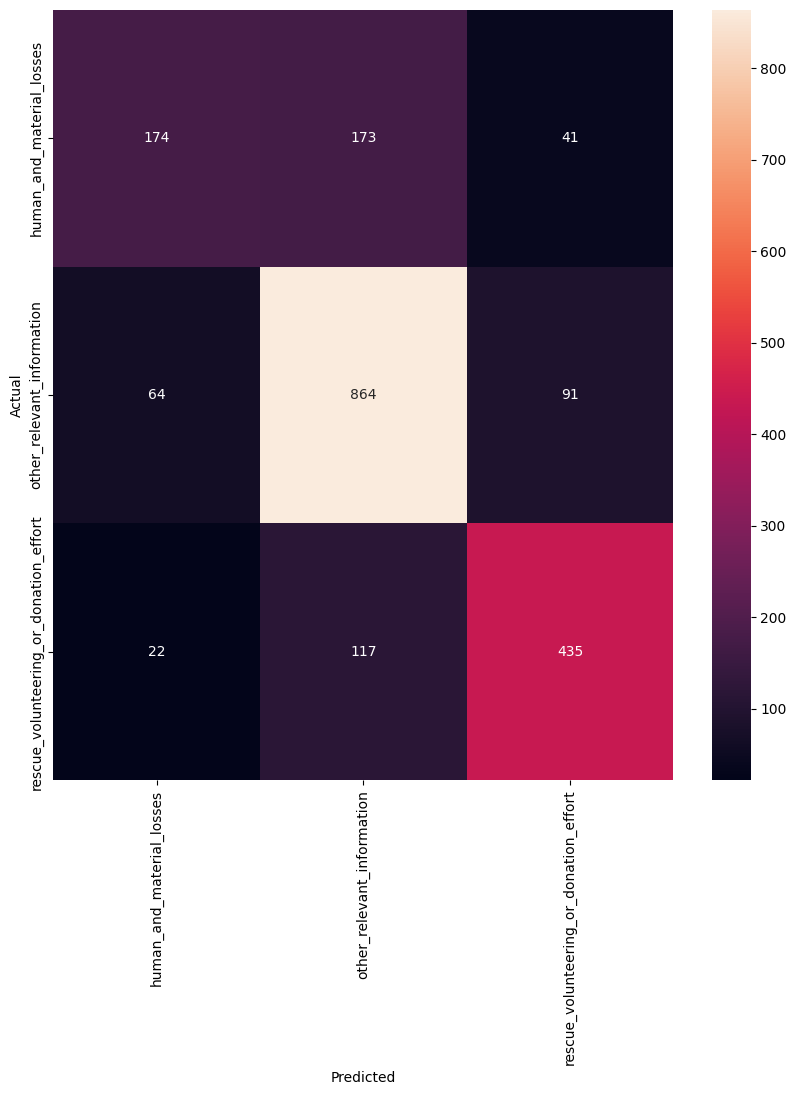

In [107]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_tri_test, y_tri_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=np.unique(y_tri), yticklabels=np.unique(y_tri))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Clasificación rescue_volunteering vs human and material losses vs others vs not humanitarian

In [108]:
y_quad = y.copy()
for i in range( len(y_quad)):
    if (y_quad[i] != 'other_relevant_information' and y_quad[i] != 'rescue_volunteering_or_donation_effort' and y_quad[i] != 'not_humanitarian'):
        y_quad[i] = 'human_and_material_losses'

In [109]:
X_quad_train, X_quad_test, y_quad_train,y_quad_test = train_test_split(X, y_quad, test_size=0.2, random_state=42, stratify=y_quad)

In [110]:
tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_quad_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_quad_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)

##### Linear SVC

In [111]:
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_quad_train)

y_quad_pred = classifier.predict(X_test_embeddings)

In [112]:

accuracy = accuracy_score(y_quad_test, y_quad_pred)
precision = precision_score(y_quad_test, y_quad_pred,average='macro')
recall = recall_score(y_quad_test, y_quad_pred,average='macro')
f1 = f1_score(y_quad_test, y_quad_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6287769784172662
Precision: 0.6355020600645608
Recall: 0.6123762618564802
F1 Score: 0.6191671825458188


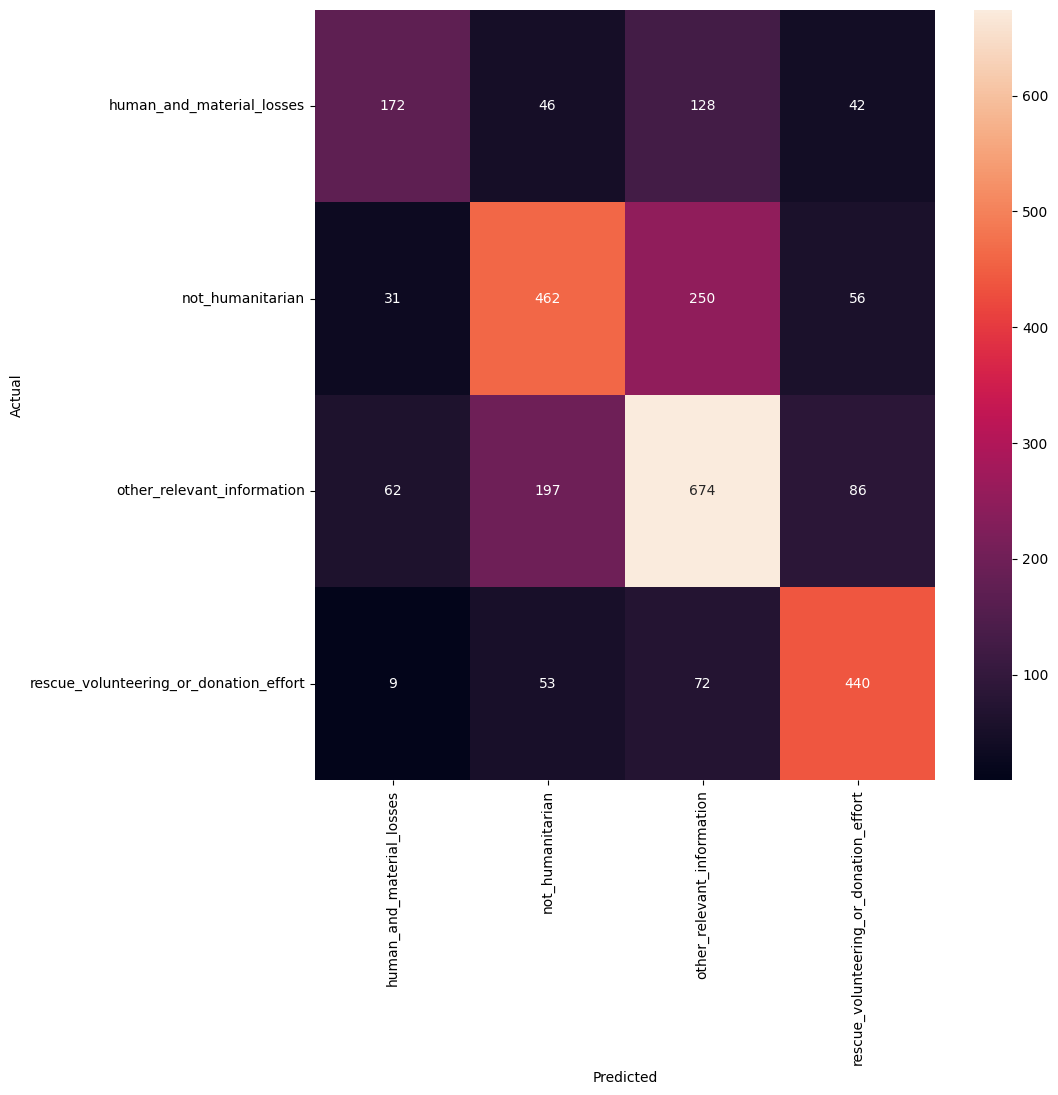

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_quad_test, y_quad_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=np.unique(y_quad), yticklabels=np.unique(y_quad))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##### DecisionTreeClassifier 

In [114]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train_embeddings, y_quad_train)
y_quad_pred = classifier.predict(X_test_embeddings)

In [115]:
accuracy = accuracy_score(y_quad_test, y_quad_pred)
precision = precision_score(y_quad_test, y_quad_pred,average='macro')
recall = recall_score(y_quad_test, y_quad_pred,average='macro')
f1 = f1_score(y_quad_test, y_quad_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.4223021582733813
Precision: 0.40550256179404975
Recall: 0.40680748780539894
F1 Score: 0.4060590102849052


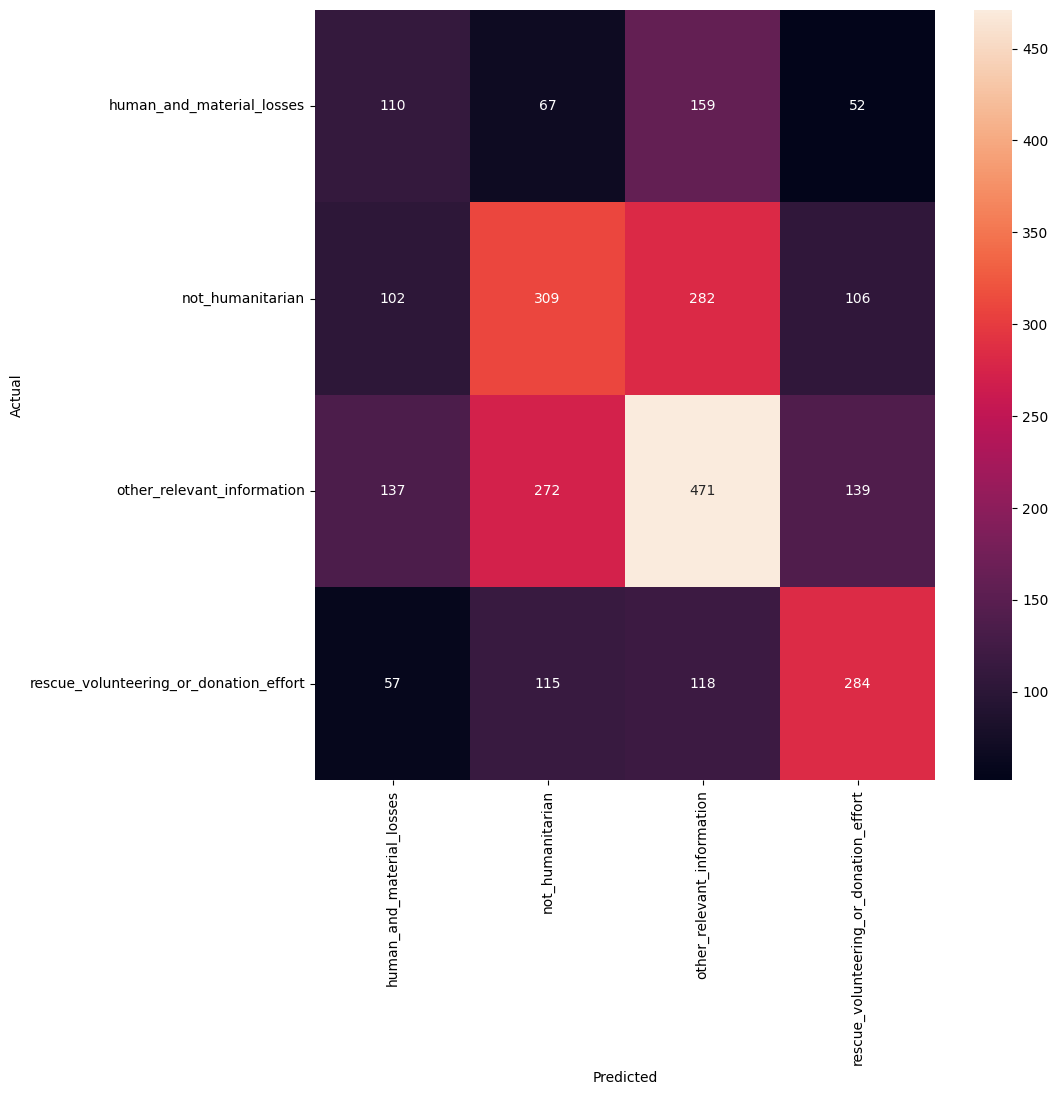

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_quad_test, y_quad_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=np.unique(y_quad), yticklabels=np.unique(y_quad))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##### RandomForestClassifier

In [117]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train_embeddings, y_quad_train)
y_quad_pred = classifier.predict(X_test_embeddings)

In [118]:
accuracy = accuracy_score(y_quad_test, y_quad_pred)
precision = precision_score(y_quad_test, y_quad_pred,average='macro')
recall = recall_score(y_quad_test, y_quad_pred,average='macro')
f1 = f1_score(y_quad_test, y_quad_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5881294964028777
Precision: 0.6471163844743723
Recall: 0.5358464915182092
F1 Score: 0.5524580159706383


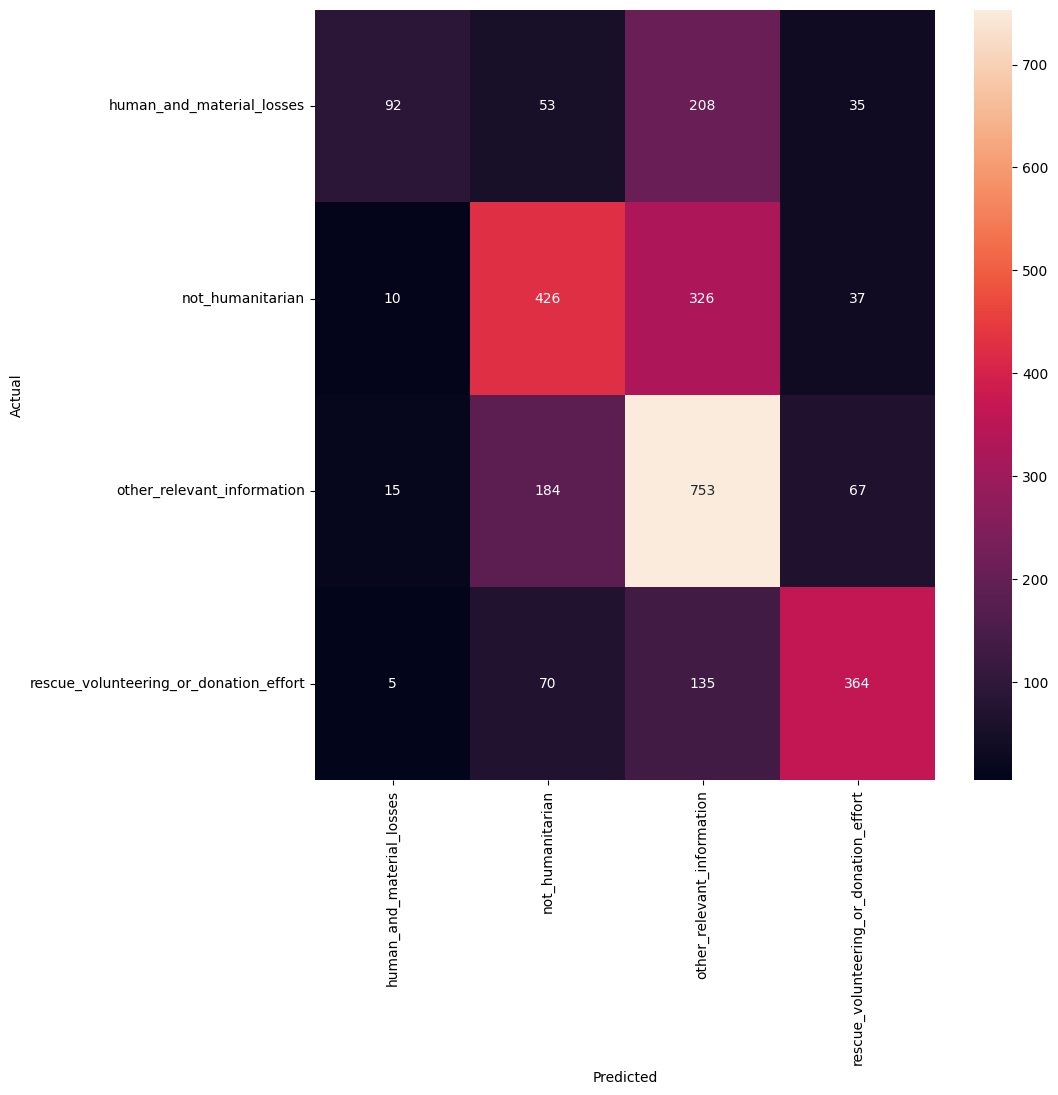

In [119]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_quad_test, y_quad_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=np.unique(y_quad), yticklabels=np.unique(y_quad))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##### NaiveBayes

###### Gaussian

In [120]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train_embeddings, y_quad_train)
y_quad_pred = classifier.predict(X_test_embeddings)

In [121]:
accuracy = accuracy_score(y_quad_test, y_quad_pred)
precision = precision_score(y_quad_test, y_quad_pred,average='macro')
recall = recall_score(y_quad_test, y_quad_pred,average='macro')
f1 = f1_score(y_quad_test, y_quad_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5960431654676259
Precision: 0.5874213792028596
Recall: 0.602801975686037
F1 Score: 0.593473739118166


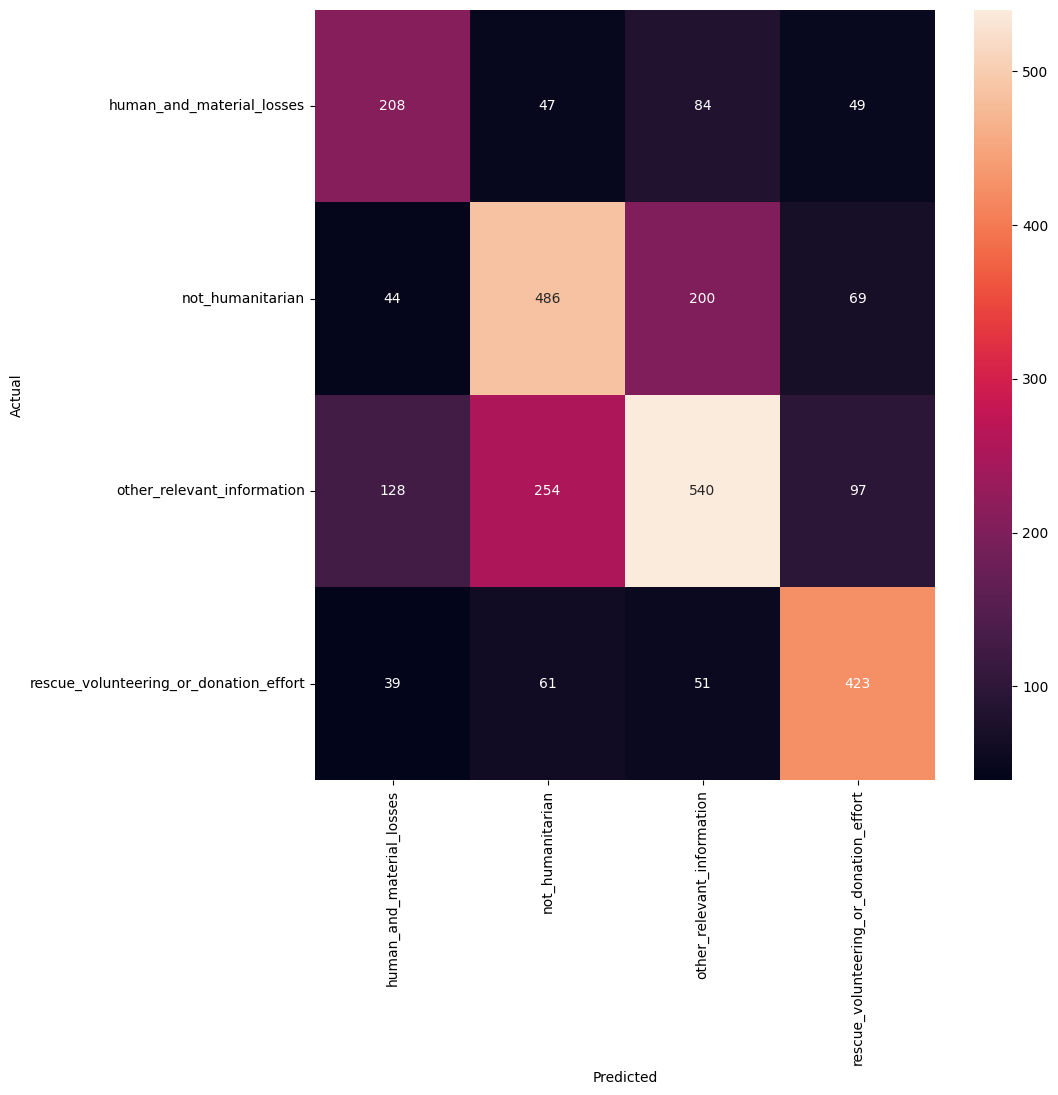

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_quad_test, y_quad_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=np.unique(y_quad), yticklabels=np.unique(y_quad))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [68]:
dftest=df_con_nan[df_con_nan["text_human"].isna() ]
dftest

,id,lang,text,favorite_count,retweet_count,possibly_sensitive,created_at,is_quote_status,entities_hashtags_text,entities_urls,user_location,reply_count,quote_count,has_image,json_name,text_info,text_info_conf,text_human,text_human_conf,fecha
1,917787635946524674,en,Wildfires raging through Northern California a...,7,5,False,Tue Oct 10 16:23:18 +0000 2017,False,None,True,None,0.0,4.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-10 16:23:18+00:00
2,917500054742605829,en,"PLS SHARE: We’re capturing wildfire response, ...",289,479,False,Mon Oct 09 21:20:34 +0000 2017,False,None,True,"Sacramento, California",9.0,25.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-09 21:20:34+00:00
3,917623252264062976,en,California's raging wildfires as you've never ...,228,216,False,Tue Oct 10 05:30:06 +0000 2017,False,None,True,None,19.0,18.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-10 05:30:06+00:00
6,917715928271507456,en,Southern California fire shrouds Disneyland An...,133,76,False,Tue Oct 10 11:38:22 +0000 2017,False,None,True,U.S.A.,25.0,7.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-10 11:38:22+00:00
8,917433167014920192,en,California wildfires destroy more than 50 stru...,1,2,False,Mon Oct 09 16:54:46 +0000 2017,False,[KAKEnews],True,"Wichita, Kansas",0.0,0.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-09 16:54:46+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,869952041698811904,en,Please support my GoFundMe campaign: https://t...,1,1,False,Wed May 31 16:21:44 +0000 2017,False,None,True,"New Mexico, USA",0.0,0.0,True,srilanka_floods,NaN,NaN,NaN,NaN,2017-05-31 16:21:44+00:00
15963,869096735427014656,en,Hat's off to this Man Palitha Thewarapperuma \...,7,4,False,Mon May 29 07:43:03 +0000 2017,False,"[Respect, FloodSL, lka, greatpeople]",False,Sri Lanka යකෝ,0.0,0.0,True,srilanka_floods,NaN,NaN,NaN,NaN,2017-05-29 07:43:03+00:00
15982,847154724109533190,en,Portrait double exposure ❤️⭐️❤️⭐️❤️Antonio Mor...,186,123,False,Wed Mar 29 18:33:20 +0000 2017,False,None,False,"Rhône-Alpes, France",0.0,0.0,True,srilanka_floods,NaN,NaN,NaN,NaN,2017-03-29 18:33:20+00:00
15999,848529356376997888,en,Ross MacDonald // Lollapalooza Chile 2017 by P...,488,193,False,Sun Apr 02 13:35:38 +0000 2017,False,None,False,None,0.0,0.0,True,srilanka_floods,NaN,NaN,NaN,NaN,2017-04-02 13:35:38+00:00


In [69]:
text = dftest["text"][15999]
print(text)
tokenize_text = remove_stopword_tokens(simple_preprocess(text))
print(tokenize_text)
vectors = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in tokenize_text]]
embeddings = average_vectors(vectors)
l = classifier.predict(embeddings)
print(l[0])

Ross MacDonald // Lollapalooza Chile 2017 by Pedro Mora https://t.co/bFBZFarZO3
['ross', 'macdonald', 'lollapalooza', 'chile', 'pedro', 'mora', 'https', 'bfbzfarzo']
not_humanitarian


### Test de cv

In [59]:
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_tri_train)

y_tri_pred = classifier.predict(X_test_embeddings)

In [60]:
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

accuracy = accuracy_score(y_tri_test, y_tri_pred)
precision = precision_score(y_tri_test, y_tri_pred,average='macro')
recall = recall_score(y_tri_test, y_tri_pred,average='macro')
f1 = f1_score(y_tri_test, y_tri_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



predict_y_train = classifier.predict(X_train_embeddings)
predict_y_test = classifier.predict(X_test_embeddings)    
accuracy_train = classifier.score(X_train_embeddings,y_tri_train) 
accuracy_test =  classifier.score(X_test_embeddings,y_tri_test)  

#conduct cross-validation 

cv = ShuffleSplit(10,test_size=0.2, random_state=None)
scores = cross_val_score(classifier,X_train_embeddings,y_tri_train,cv = cv)
#score_mean = mean(scores) 


print(scores)


Accuracy: 0.7435638566380616
Precision: 0.7283755699122539
Recall: 0.6847278059412208
F1 Score: 0.6982466905368061
[0.74511041 0.74826498 0.72429022 0.74826498 0.7444795  0.74826498
 0.74763407 0.74195584 0.74637224 0.73123028]


In [62]:
text = df_con_nan[df_con_nan["id"]==907017142486401024]["text"].tolist()[0]
text = "There was a female unit of NDRF which was sent to Turkey in search & rescue mission when they suffered from earthquake. These same women would have done the same job is they were deployed where the incident happened. That's what every NDRF person does. Just for your information."
print(text)
tokenize_text = remove_stopword_tokens(simple_preprocess(text))
print(tokenize_text)
vectors = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in tokenize_text]]
embeddings = average_vectors(vectors)
l = classifier.predict(embeddings)
print(l[0])

There was a female unit of NDRF which was sent to Turkey in search & rescue mission when they suffered from earthquake. These same women would have done the same job is they were deployed where the incident happened. That's what every NDRF person does. Just for your information.
['female', 'unit', 'ndrf', 'sent', 'turkey', 'search', 'rescue', 'mission', 'suffered', 'earthquake', 'women', 'job', 'deployed', 'incident', 'happened', 'ndrf', 'person', 'information']
rescue_volunteering_or_donation_effort


### Otros

#### Model 2

In [72]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

classifier = Pipeline([
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1e5)),
               ])
classifier.fit(X_train_embeddings, y_quad_train)

y_quad_pred = classifier.predict(X_test_embeddings)

c:\Users\jczkr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_quad_test, y_quad_pred)
precision = precision_score(y_quad_test, y_quad_pred,average='macro')
recall = recall_score(y_quad_test, y_quad_pred,average='macro')
f1 = f1_score(y_quad_test, y_quad_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6323741007194245
Precision: 0.637200119001065
Recall: 0.6217537374138947
F1 Score: 0.6269982360175532


#### Model 3

In [77]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier 
from sklearn.pipeline import Pipeline

classifier = Pipeline([
                ('tfidf', TfidfTransformer()),
                ("sgd", SGDClassifier(loss="hinge", alpha=0.00001)),
               ])
classifier.fit(X_train_embeddings, y_quad_train)

y_quad_pred = classifier.predict(X_test_embeddings)

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_quad_test, y_quad_pred)
precision = precision_score(y_quad_test, y_quad_pred,average='macro')
recall = recall_score(y_quad_test, y_quad_pred,average='macro')
f1 = f1_score(y_quad_test, y_quad_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6305755395683453
Precision: 0.6226955636568091
Recall: 0.6348216562178901
F1 Score: 0.6257390328956067


### test con tweets reales

In [90]:
dftest=df_con_nan[df_con_nan["text_human"].isna() ]
dftest

,id,lang,text,favorite_count,retweet_count,possibly_sensitive,created_at,is_quote_status,entities_hashtags_text,entities_urls,user_location,reply_count,quote_count,has_image,json_name,text_info,text_info_conf,text_human,text_human_conf,fecha
1,917787635946524674,en,Wildfires raging through Northern California a...,7,5,False,Tue Oct 10 16:23:18 +0000 2017,False,None,True,None,0.0,4.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-10 16:23:18+00:00
2,917500054742605829,en,"PLS SHARE: We’re capturing wildfire response, ...",289,479,False,Mon Oct 09 21:20:34 +0000 2017,False,None,True,"Sacramento, California",9.0,25.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-09 21:20:34+00:00
3,917623252264062976,en,California's raging wildfires as you've never ...,228,216,False,Tue Oct 10 05:30:06 +0000 2017,False,None,True,None,19.0,18.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-10 05:30:06+00:00
6,917715928271507456,en,Southern California fire shrouds Disneyland An...,133,76,False,Tue Oct 10 11:38:22 +0000 2017,False,None,True,U.S.A.,25.0,7.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-10 11:38:22+00:00
8,917433167014920192,en,California wildfires destroy more than 50 stru...,1,2,False,Mon Oct 09 16:54:46 +0000 2017,False,[KAKEnews],True,"Wichita, Kansas",0.0,0.0,True,california_wildfires,NaN,NaN,NaN,NaN,2017-10-09 16:54:46+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,869952041698811904,en,Please support my GoFundMe campaign: https://t...,1,1,False,Wed May 31 16:21:44 +0000 2017,False,None,True,"New Mexico, USA",0.0,0.0,True,srilanka_floods,NaN,NaN,NaN,NaN,2017-05-31 16:21:44+00:00
15963,869096735427014656,en,Hat's off to this Man Palitha Thewarapperuma \...,7,4,False,Mon May 29 07:43:03 +0000 2017,False,"[Respect, FloodSL, lka, greatpeople]",False,Sri Lanka යකෝ,0.0,0.0,True,srilanka_floods,NaN,NaN,NaN,NaN,2017-05-29 07:43:03+00:00
15982,847154724109533190,en,Portrait double exposure ❤️⭐️❤️⭐️❤️Antonio Mor...,186,123,False,Wed Mar 29 18:33:20 +0000 2017,False,None,False,"Rhône-Alpes, France",0.0,0.0,True,srilanka_floods,NaN,NaN,NaN,NaN,2017-03-29 18:33:20+00:00
15999,848529356376997888,en,Ross MacDonald // Lollapalooza Chile 2017 by P...,488,193,False,Sun Apr 02 13:35:38 +0000 2017,False,None,False,None,0.0,0.0,True,srilanka_floods,NaN,NaN,NaN,NaN,2017-04-02 13:35:38+00:00


In [105]:
#text = df_con_nan[df_con_nan["id"]==907017142486401024]["text"].tolist()[0]

#text = "There was a female unit of NDRF which was sent to Turkey in search & rescue mission when they suffered from earthquake. These same women would have done the same job is they were deployed where the incident happened. That's what every NDRF person does. Just for your information."
text = dftest["text"][1]
print(text)
tokenize_text = remove_stopword_tokens(simple_preprocess(text))
print(tokenize_text)
vectors = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in tokenize_text]]
embeddings = average_vectors(vectors)
l = classifier.predict(embeddings)
print(l[0])

Wildfires raging through Northern California are terrifying https://t.co/dI73RFzX2i https://t.co/k4KnvIimsU
['wildfires', 'raging', 'northern', 'california', 'terrifying', 'https', 'di', 'rfzx', 'https', 'knviimsu']
other_relevant_information
